In [ ]:
# user parameters
key = open('../api-key/omdb key.txt', 'r').read()

In [ ]:
# extract top 100 movie IDs from IMDB
# https://abdulrwahab.medium.com/how-to-build-a-python-web-scraper-to-capture-imdb-top-100-movies-908bf9b6bc19
import requests
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

# Step 2: Grab the top 150
genres = ['Comedy', 'Action', 'Animation', 'Romance', 'Horror']
# for each genre grab the top 50 movies
imdb_url = "https://www.imdb.com/search/title/?genres={}&explore=genres&title_type=feature&ref_=ft_movie_0"

# Step 3: Set headers.
headers = {"Accept-Language": "en-US, en;q=0.5"}


imdbid_list = []
for genre in genres:
    # Step 4: Save all values to the results objects coming back from the .get on IMDb URL.
    results = requests.get(imdb_url.format(genre), headers=headers)

    # Step 5: Parse the results object to movie_soup using the html parser.
    movie_soup = BeautifulSoup(results.text, "html.parser")

    # Step 7: Create a movie_div object to find all div objects in movie_soup.
    movie_div = movie_soup.find_all('div', class_='lister-item mode-advanced')

    for store in movie_div:
        imdbID = store.img.get('data-tconst')
        imdbid_list.append(imdbID)

In [ ]:
# remove duplicates to make sure we don't query for the same movie multiple times
imdbid_list = list(dict.fromkeys(imdbid_list))
print(len(imdbid_list))

In [ ]:
import pandas as pd
import requests
import json

# helper functions
def getratings(ratinglist):
    """ 
     TODO: comment this helper function
       """
    returnlist = []
    for rating in ratinglist:
        dict_r = dict(rating)
        return_r = [dict_r['Source'], dict_r['Value']]
        returnlist.append(return_r)
    return returnlist

def load_data(key, idlist):
    """ 
    load_data extracts movie data from OMDB API, based on a list of words provided in searchlist
    :param key: apikey to access the api
    :param searchlist: list of stings to search for in movie titles
    :return:  for each word in searchlist, 10 movies with the word in its title and corresponding omdb data
    """
    # initialize empty dataframe
    moviedf = pd.DataFrame()

    # for each imdb id, extract data from omdb api
    for id in idlist:
        response_data = requests.get('http://www.omdbapi.com/?apikey={}&i={}&plot=full'.format(key, id))
        data_txt = response_data.text
        if 'Title' in data_txt:
            parse_data = pd.read_json(data_txt)
            # convert multiple rows per movie into 1 row per movie by groupby and applying a function to 'Ratings' column
            groupby_cols = list(parse_data.columns)
            groupby_cols.remove('Ratings')
            parse_data = (parse_data.groupby(groupby_cols)
            .agg({'Ratings': lambda x: getratings(x)},axis=1)
            .reset_index())
            
            # add data to the final dataframe
            moviedf = pd.concat([moviedf, parse_data])
    # make sure there are no duplicates
    moviedf.reset_index(drop=True, inplace=True)
    moviedf = moviedf.loc[moviedf.astype(str).drop_duplicates().index]
    moviedf.to_excel('test.xlsx')
    return moviedf

In [1]:
import pandas as pd
# moviedf = load_data(key, imdbid_list)
moviedf = pd.read_excel('backup data.xlsx')
moviedf.head()

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Ratings
0,0,Haunted Mansion,2023,PG-13,28 Jul 2023,122 min,"Comedy, Drama, Family",Justin Simien,Katie Dippold,"Rosario Dawson, Jamie Lee Curtis, Winona Ryder",...,NaN,NaN,tt1695843,movie,NaN,NaN,NaN,NaN,True,"[['Rotten Tomatoes', '42%']]"
1,1,Babylon,2022,R,23 Dec 2022,189 min,"Comedy, Drama, History",Damien Chazelle,Damien Chazelle,"Brad Pitt, Margot Robbie, Jean Smart",...,7.2,"130,837",tt10640346,movie,31 Jan 2023,"$15,351,455",NaN,NaN,True,"[['Internet Movie Database', '7.2/10'], ['Rott..."
2,2,Asteroid City,2023,PG-13,23 Jun 2023,105 min,"Comedy, Drama, Romance",Wes Anderson,"Wes Anderson, Roman Coppola","Jason Schwartzman, Scarlett Johansson, Tom Hanks",...,7.0,"45,973",tt14230388,movie,11 Jul 2023,"$27,272,775",NaN,NaN,True,"[['Internet Movie Database', '7.0/10'], ['Rott..."
3,3,The Out-Laws,2023,R,07 Jul 2023,95 min,"Action, Comedy, Crime",Tyler Spindel,"Ben Zazove, Evan Turner","Adam Devine, Pierce Brosnan, Ellen Barkin",...,5.4,"22,052",tt11274492,movie,NaN,NaN,NaN,NaN,True,"[['Internet Movie Database', '5.4/10'], ['Meta..."
4,4,No Hard Feelings,2023,R,23 Jun 2023,103 min,"Comedy, Romance",Gene Stupnitsky,"Gene Stupnitsky, John Phillips","Jennifer Lawrence, Andrew Barth Feldman, Laura...",...,6.7,"22,813",tt15671028,movie,NaN,"$49,642,520",NaN,NaN,True,"[['Internet Movie Database', '6.7/10'], ['Meta..."


In [2]:
print(len(moviedf))

167


In [3]:
num_cols = ['Runtime', 'Metascore', 'imdbRating', 'imdbVotes', 'BoxOffice']
text_cols = ['Plot', 'Title']
X_cols = text_cols + num_cols
y_col = 'Genre'

In [4]:
# remove rows with NAN genre
moviedf = moviedf[moviedf['Genre'].notna()]

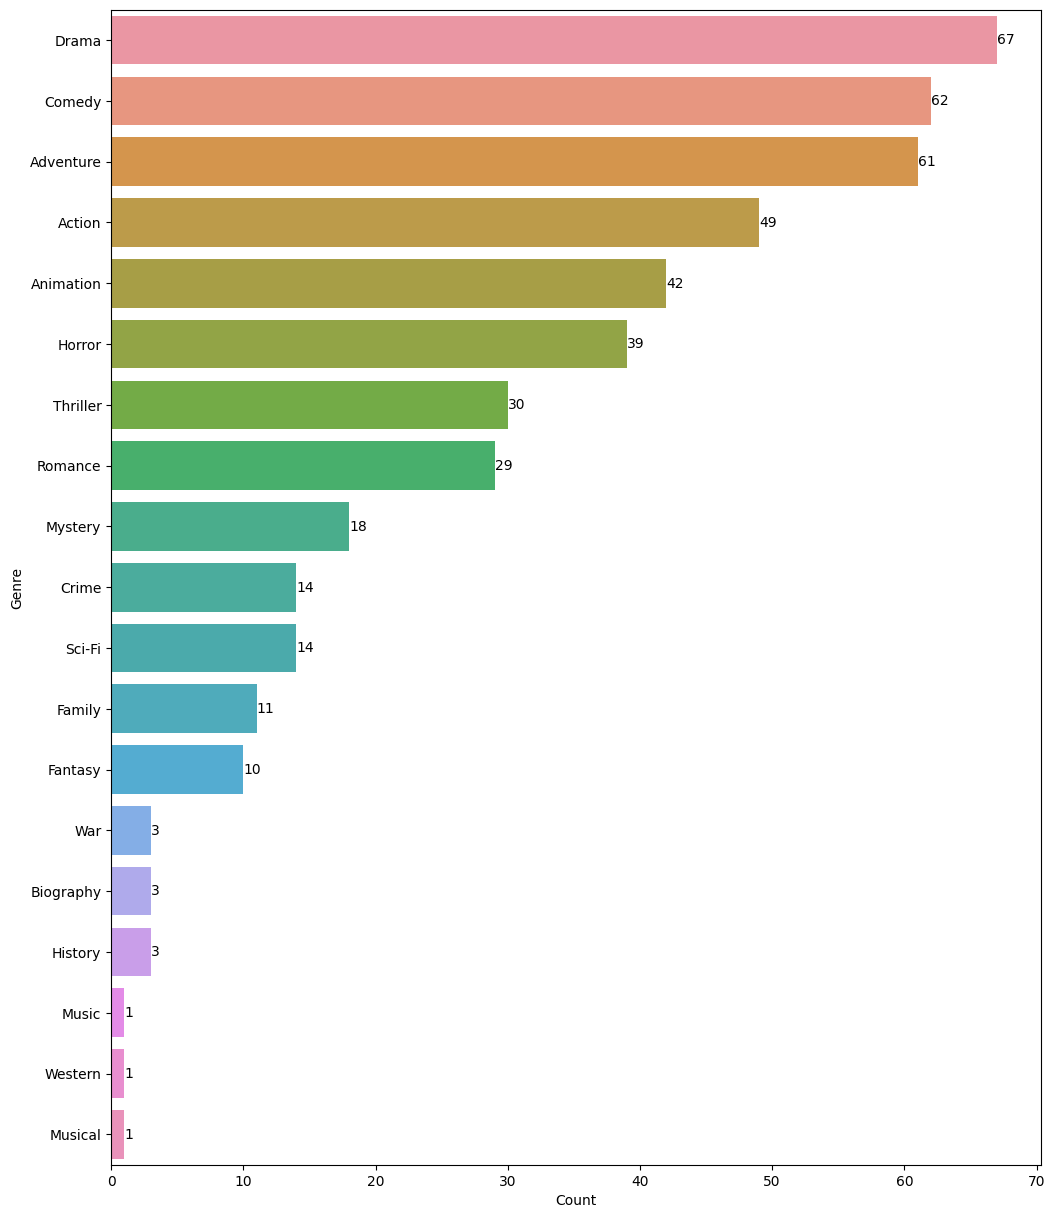

In [5]:

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

moviedf[y_col] = moviedf[y_col].apply(lambda x: x.split(', '))
genre_list = [item for sublist in moviedf['Genre'] for item in sublist]
count = Counter(genre_list)
countdf = pd.DataFrame.from_dict(count, orient='index', columns=['Count']).reset_index().sort_values(by='Count', ascending=False)
# countdf
# g = moviedf.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=countdf, x="Count", y = "index") 
for i in ax.containers:
    ax.bar_label(i,)
ax.set(ylabel = 'Genre') 
plt.show()

In [6]:
import re, string

# remove classes with less than 4 instances
def remove_genre(x, genre):
    if genre in x:
        x.remove(genre)
    return x

# preprocess text data 
def process_text(text):
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())
    return text

    

less_than_4 = list(countdf.loc[countdf['Count'] < 4]['index'])
for genre in less_than_4:
    moviedf['Genre'] = moviedf['Genre'].apply(lambda x: remove_genre(x, genre))

X = moviedf['Plot'].apply(process_text)

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
y = multilabel_binarizer.fit_transform(moviedf[y_col])
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
multilabel_binarizer.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller'], dtype=object)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(133,) (34,) (133, 13) (34, 13)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
import torch

num_classes = len(multilabel_binarizer.classes_)

# BERT-based Feature Extractor
class BertFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=128):
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        input_ids = []
        attention_masks = []

        for text in X:
            encoded = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt',  # Use PyTorch tensors instead of TensorFlow tensors
                truncation=True
            )

            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

        input_ids = torch.cat(input_ids, axis=0)  # Use torch.cat instead of tf.concat
        attention_masks = torch.cat(attention_masks, axis=0)  # Use torch.cat instead of tf.concat

        with torch.no_grad():
            embeddings = self.bert_model(input_ids, attention_mask=attention_masks)[0]
            flattened_embeddings = embeddings[:, 0, :]

        return flattened_embeddings

# Text Preprocessing Function (Example: lowercase and remove punctuation)
def text_preprocessing(text):
    return text.lower().replace(",", "").replace(".", "")

data_pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text_feat', TfidfVectorizer(stop_words='english', analyzer='word', preprocessor=text_preprocessing)),
            ('bert_feat', BertFeatureExtractor()),
        ])),
        ('clf', OneVsRestClassifier(LogisticRegression()))
])



c:\Users\Evie\Documents\Techonomy code\plantclassifier\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Parameters for Grid Search
param_grid = {
    # 'features__text_feat__max_df': [0.9, 0.95],  # TfidfVectorizer parameters
    # 'features__text_feat__ngram_range': [(1, 1), (1, 2)],
    'clf__estimator__C': [0.1, 1, 10],  # LogisticRegression parameters
    # 'clf__estimator__class_weight': [None, 'balanced']
}

# Grid Search
grid_search= GridSearchCV(data_pipeline, param_grid, cv=3, return_train_score=True, refit=True,
                        scoring='f1_micro',
                        verbose=1)
grid_search.fit(X_train, y_train)

# Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Best Model from Grid Search
best_model = grid_search.best_estimator_

# Predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Plot train vs test scores
train_scores = grid_search.cv_results_['mean_train_score']
test_scores = grid_search.cv_results_['mean_test_score']



In [ ]:
from sklearn.metrics import f1_score

data_pipeline.fit(X_train, y_train)

# Compute train and test scores
train_score = f1_score(y_train, data_pipeline.predict(X_train), average='micro')
test_score = f1_score(y_test, data_pipeline.predict(X_test), average='micro')

train_score, test_score


In [ ]:
# Compute F1 scores for different thresholds for the best model
thresholds = np.arange(0.1, 1.0, 0.1)
f1_scores_micro = []
f1_scores_macro = []

for threshold in thresholds:
    y_val_probs = data_pipeline.predict_proba(X_test)  # Assuming binary classifiers
    y_val_pred = (y_val_probs >= threshold).astype(int)
    f1_scores_micro.append(f1_score(y_test, y_val_pred, average='micro'))
    f1_scores_macro.append(f1_score(y_test, y_val_pred, average='macro'))

# Plot the F1-score vs. threshold for the best model
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores_micro, marker='o', label='micro f1 score')
plt.plot(thresholds, f1_scores_macro, marker='o', label='macro f1 score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold for Best Model')
plt.grid(True)
plt.show()


In [ ]:
# Performance metric
from sklearn.metrics import f1_score

y_pred = grid_search.predict(X_test)
print(y_pred)

# label_predictions = multilabel_binarizer.inverse_transform(y_pred)
# # evaluate performance
# f1_score(y_test, y_pred, average="micro")
# print(label_predictions)

In [ ]:
# predict probabilities
y_pred_prob = grid_search.predict_proba(X_test_plot)
print(list(y_pred_prob[0]))
# t = 0.3 # threshold value
# y_pred_new = (y_pred_prob >= t).astype(int)
# # evaluate performance
# f1_score(y_test, y_pred_new, average="micro")
# # TODO create plot for threshold value

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.base import BaseEstimator, TransformerMixin

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

num_classes = len(multilabel_binarizer.classes_)

# BERT-based Feature Extractor with Fine-Tuning
class BertFineTunedFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=128, batch_size=16, num_epochs=3, learning_rate=2e-5):
        self.max_length = max_length
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None

    def fit(self, X, y):
        # Convert data to tensors
        X_tensors = tokenizer(list(X), padding=True, truncation=True, return_tensors='pt')
        y_tensors = torch.FloatTensor(y)
        
        # Create DataLoader for batching
        train_dataset = torch.utils.data.TensorDataset(X_tensors['input_ids'], X_tensors['attention_mask'], y_tensors)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        # Fine-tuning loop
        self.model = NeuralNetwork(num_classes=num_classes).to(self.device)
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        total_steps = len(train_loader) * self.num_epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        criterion = torch.nn.BCEWithLogitsLoss()

        for epoch in range(self.num_epochs):
            total_loss = 0.0
            self.model.train()
            for step, batch in enumerate(train_loader):
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(self.device), attention_mask.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()

                total_loss += loss.item()

            average_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {average_loss:.4f}")

        return self

    def transform(self, X):
        # Convert data to tensors
        X_tensors = tokenizer(list(X), padding=True, truncation=True, return_tensors='pt')
        
        # Move the model to the appropriate device (GPU or CPU)
        self.model = self.model.to(self.device)
        self.model.eval()

        with torch.no_grad():
            # Get the BERT embeddings
            X_tensors = {key: value.to(self.device) for key, value in X_tensors.items()}
            embeddings = self.model(input_ids=X_tensors['input_ids'], attention_mask=X_tensors['attention_mask'])
            
        return embeddings


# Define the NeuralNetwork class
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super(NeuralNetwork, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(768, 256)  # Adjust the input size to match BERT output (768 for 'bert-base-uncased')
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        # Apply fully connected layers
        x = self.fc1(pooled_output)
        x = nn.ReLU()(x)
        x = nn.Dropout(0.5)(x)
        x = self.fc2(x)
        return x


# Update the data pipeline
bert_pipeline = Pipeline([
    ("bert_features", BertFineTunedFeatureExtractor(batch_size=16, num_epochs=3, learning_rate=2e-5)),  # The fine-tuned BERT-based pipeline
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

X_train_plot = X_train['Plot']
# Fit the pipeline with the fine-tuned BERT embeddings
data_pipeline.fit(X_train_plot, y_train)


In [ ]:
from sklearn.metrics import hamming_loss, jaccard_score, precision_score, recall_score, f1_score
X_test_plot = X_test['Plot']
y_pred = data_pipeline.predict(X_test_plot)

# Compute evaluation metrics
hamming_loss_value = hamming_loss(y_test, y_pred)
jaccard_micro = jaccard_score(y_test, y_pred, average='micro')
jaccard_macro = jaccard_score(y_test, y_pred, average='macro')
precision_micro = precision_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_micro = recall_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Hamming Loss:", hamming_loss_value)
print("Jaccard Similarity (Micro):", jaccard_micro)
print("Jaccard Similarity (Macro):", jaccard_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Macro):", precision_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Macro):", recall_macro)
print("F1-score (Micro):", f1_micro)
print("F1-score (Macro):", f1_macro)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    labels = ['True Neg','False Pos','False Neg','True Pos']
    labels = np.asarray(labels).reshape(2,2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", ax=axes, cmap='Blues', annot_kws={"size": 16})
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class - " + class_label)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

matr = multilabel_confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
    
for axes, cfs_matrix, label in zip(ax.flatten(), matr, multilabel_binarizer.classes_):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()


In [ ]:
import joblib

joblib.dump(grid_search, 'models/movie_model_pipeline.pkl')
joblib.dump(multilabel_binarizer, 'models/binarizer.pkl')